Amines:
h1: CCN(CC)CCNC

Aldehydes:
l1: CCCCCCCCC(CCCCCC)C(=O)OC1=CC=C(C=O)C=C1
l2: CCCCCCCCCCCOC(=O)C1=CC=C(C=O)C=C1
l3: CCCCCCCCCCC(C)OC(=O)C1=CC=C(C=O)C=C1
l4: CCCCCCCCC(CC)OC(=O)C1=CC=C(C=O)C=C1
l5: CCCCCCCCC(CCCCCCCC)OC(=O)C1=CC=C(C=O)C=C1

Alkynes:
t1: C#CC1=CC=C(COC(=O)C(CCCCCC)CCCCCCCC)C=C1
t2: C#CCCCC(=O)OCCCCCCCCCCC
t3: C#CCCCC(=O)OC(C)CCCCCCCCCC
t4: C#CCCCC(=O)OC(CC)CCCCCCCC
t5: C#CCCCC(=O)OC(CCCCCCCC)CCCCCCCC
t6: C#CCCCCOC(=O)CCCCCCCCC
t7: C#CCCCCOC(=O)C(CCCCCC)CCCCCCCC
反应有效性: False

总产物数: 35
[A3_Coupling] 原产物数: 35, 去重后: 35
[A3_Coupling] 产物 SMILES 列表 (去重后):
   CCCCCCCCC(CCCCCC)C(=O)OCc1ccc(C#CC(c2ccc(OC(=O)C(CCCCCC)CCCCCCCC)cc2)N(C)CCN(CC)CC)cc1
   CCCCCCCCCCCOC(=O)CCCC#CC(c1ccc(OC(=O)C(CCCCCC)CCCCCCCC)cc1)N(C)CCN(CC)CC
   CCCCCCCCCCC(C)OC(=O)CCCC#CC(c1ccc(OC(=O)C(CCCCCC)CCCCCCCC)cc1)N(C)CCN(CC)CC
   CCCCCCCCC(CC)OC(=O)CCCC#CC(c1ccc(OC(=O)C(CCCCCC)CCCCCCCC)cc1)N(C)CCN(CC)CC
   CCCCCCCCC(CCCCCCCC)OC(=O)CCCC#CC(c1ccc(OC(=O)C(CCCCCC)CCCCCCCC)cc1)N(C)CCN(CC)CC
   CCCCCCCCCC(=O)

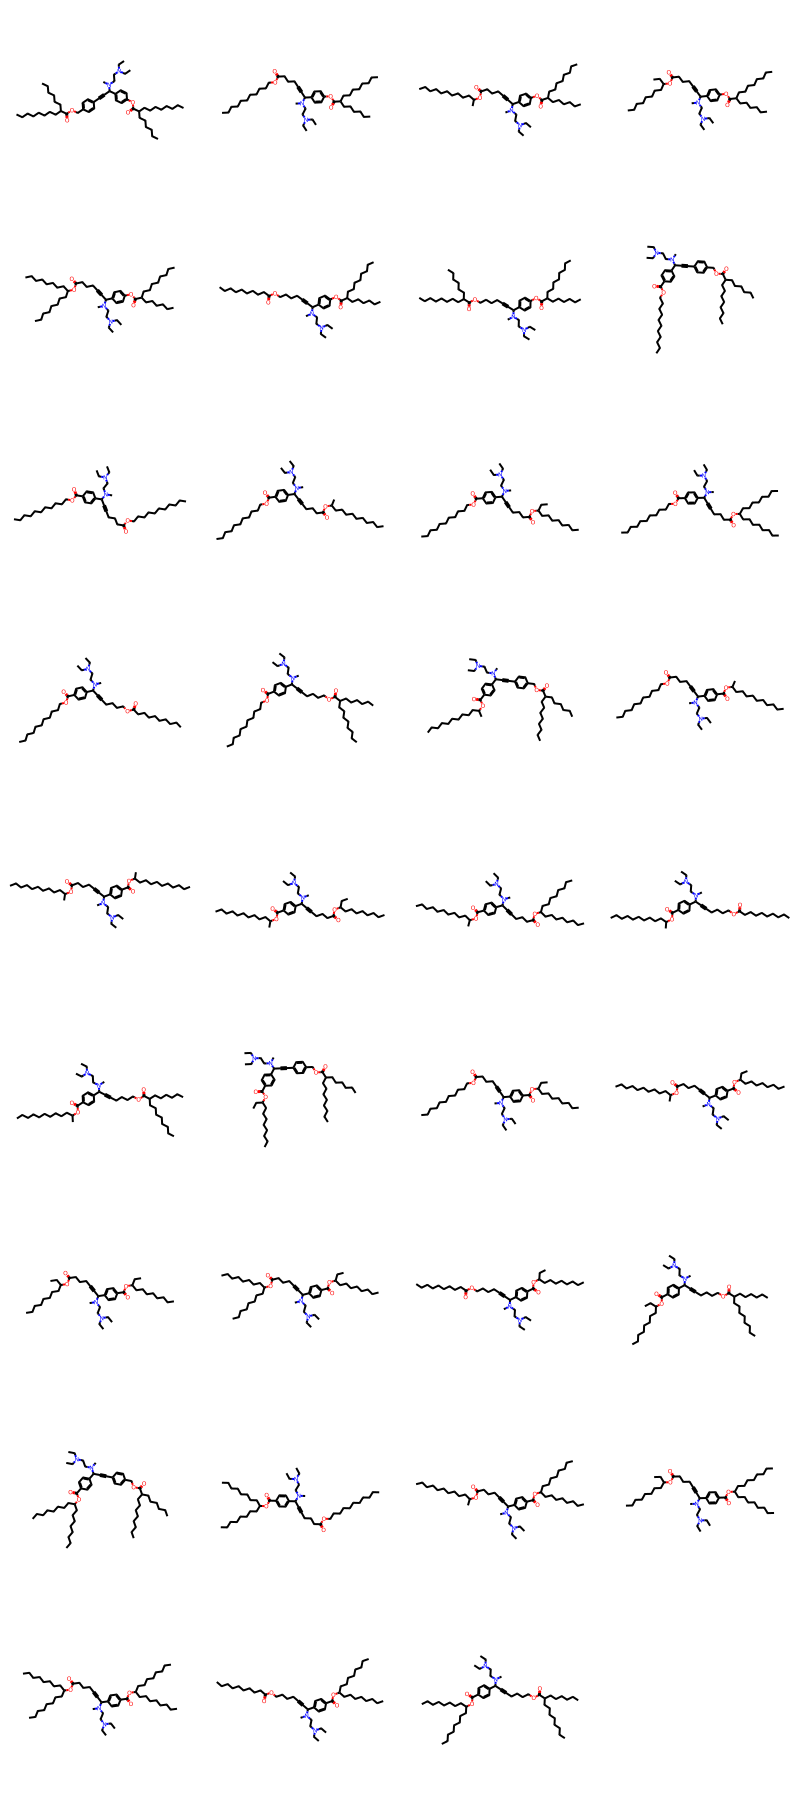

In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import csv
from IPython.display import display

# =========================== 1. 定义反应物 ===========================
# 此处依然可以通过CSV读取数据，格式为(描述, SMILES)，例如：
import csv
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from IPython.display import display

def load_reactants_from_csv(filename):
    """
    从CSV文件中读取反应物数据。
    CSV文件要求：
      - 第一列为描述（例如 "aldehydes_linker_1"）
      - 第二列为对应的 SMILES 字符串
    返回一个列表，每个元素为 (smiles, description) 的元组。
    """
    reactants = []
    with open(filename, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        # 如果CSV文件有标题行，则先跳过
        headers = next(reader, None)
        for row in reader:
            # 如果行数据不足两列则跳过
            if len(row) < 2:
                continue
            description = row[0].strip()
            smiles = row[1].strip()
            reactants.append((smiles, description))
    return reactants

# 分别从CSV中读取三类反应物数据
amines = load_reactants_from_csv('A3-1_header.csv')
aldehydes = load_reactants_from_csv('A3-1_linker.csv')
alkynes = load_reactants_from_csv('A3-1_tail.csv')

# 打印读取的内容
print("Amines:")
for smiles, desc in amines:
    print(f"{desc}: {smiles}")

print("\nAldehydes:")
for smiles, desc in aldehydes:
    print(f"{desc}: {smiles}")

print("\nAlkynes:")
for smiles, desc in alkynes:
    print(f"{desc}: {smiles}")

# =========================== 2. 定义反应 SMARTS ===========================
# 例如这里定义的反应SMARTS：
reaction_smarts = "[NH:1].[CX3H:2]=O.[CH:3]#[C:4]>>[N:1][C:2][C:3]#[C:4]"
reaction = AllChem.ReactionFromSmarts(reaction_smarts)
print("反应有效性:", reaction.IsInitialized())  # 检查反应是否正确识别

# =========================== 3. 存储产物集合 ===========================
# 这里我们将产物存储为元组 (mol, product_name)
product_mols = []

# =========================== 4. 遍历反应 ===========================
for amine_smiles, amine_desc in amines:
    for aldehyde_smiles, aldehyde_desc in aldehydes:
        for alkyne_smiles, alkyne_desc in alkynes:
            # 转换为 Mol 对象
            amine = Chem.MolFromSmiles(amine_smiles)
            aldehyde = Chem.MolFromSmiles(aldehyde_smiles)
            alkyne = Chem.MolFromSmiles(alkyne_smiles)
            if None in (amine, aldehyde, alkyne):
                print(f"[警告] 无效反应物: {amine_desc}, {aldehyde_desc}, {alkyne_desc}")
                continue

            # 执行反应
            products = reaction.RunReactants([amine, aldehyde, alkyne])
            for product_set in products:
                for product in product_set:
                    try:
                        Chem.SanitizeMol(product)  # 检查有效性
                        # 生成产品名称，格式：h1_l1_t1
                        product_name = f"{amine_desc}_{aldehyde_desc}_{alkyne_desc}"
                        product_mols.append((product, product_name))
                    except Exception as e:
                        print(f"[非法产物] 跳过: {Chem.MolToSmiles(product)} | 错误: {e}")

print(f"\n总产物数: {len(product_mols)}")

# =========================== 5. 定义处理及保存产物的函数 ===========================
def process_and_save_products(product_tuples, step_name):
    """
    处理产品：
    1) 去重 & 转 SMILES（保留产品名称）
    2) 打印 SMILES 到控制台
    3) 输出有效产物到 CSV: f"{step_name}_products.csv"
    4) （可选）在 Notebook 中显示网格图
    5) 返回去重并检查后的有效产物及其名称列表
    """
    import csv
    from rdkit import Chem
    from rdkit.Chem import Draw
    from IPython.display import display

    if not product_tuples:
        print(f"[{step_name}] 没有产物生成.")
        return [], []

    # 1) 去重（根据 SMILES 去重，同时保留名称，保留第一次出现的名称）
    unique_dict = {}
    for mol, name in product_tuples:
        smi = Chem.MolToSmiles(mol, isomericSmiles=True)
        if smi not in unique_dict:
            unique_dict[smi] = name
    unique_smiles = list(unique_dict.keys())
    print(f"[{step_name}] 原产物数: {len(product_tuples)}, 去重后: {len(unique_smiles)}")

    # 2) 在控制台打印 SMILES 列表
    print(f"[{step_name}] 产物 SMILES 列表 (去重后):")
    for smi in unique_smiles:
        print("  ", smi)

    # 3) 转回 Mol，并进行 Sanitize 检查，同时收集有效产品的名称
    valid_mols = []
    valid_names = []
    invalid_smiles = []
    for smi in unique_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            print(f"[警告] 无法从 SMILES 解析: {smi}")
            invalid_smiles.append(smi)
            continue
        try:
            Chem.SanitizeMol(mol)
            valid_mols.append(mol)
            valid_names.append(unique_dict[smi])
        except Exception as e:
            print(f"[非法产物] SMILES: {smi} | 错误: {e}")
            invalid_smiles.append(smi)
    print(f"[{step_name}] Sanitize 检查后有效产物数: {len(valid_mols)}，非法产物数: {len(invalid_smiles)}")

    # 4) 保存有效产物 CSV（包括编号、名称和 SMILES）
    csv_filename = f"{step_name}_products.csv"
    with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["编号", "名称", "SMILES"])
        for idx, (mol, name) in enumerate(zip(valid_mols, valid_names), start=1):
            smi = Chem.MolToSmiles(mol, isomericSmiles=True)
            writer.writerow([idx, name, smi])
    print(f"[{step_name}] 有效产物 CSV 已保存: {csv_filename}")

    # 5) 保存非法产物 CSV（如果有）
    if invalid_smiles:
        invalid_csv_filename = f"{step_name}_invalid_products.csv"
        with open(invalid_csv_filename, "w", newline="", encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["SMILES"])
            for smi in invalid_smiles:
                writer.writerow([smi])
        print(f"[{step_name}] 非法产物 CSV 已保存: {invalid_csv_filename}")

    # 6) 在 Notebook 中显示网格图
    if valid_mols:
        img = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(200, 200))
        display(img)
        # 如需保存图片，可启用如下代码：
        # png_filename = f"{step_name}_products.png"
        # img_data = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(200, 200), returnPNG=True)
        # with open(png_filename, "wb") as f:
        #     f.write(img_data)
        # print(f"[{step_name}] 图片已保存: {png_filename}")

    return valid_mols, valid_names

# =========================== 6. 调用处理函数 ===========================
final_unique_products, final_product_names = process_and_save_products(product_mols, "A3_Coupling")


In [10]:
import csv
import os
from rdkit import Chem
from rdkit.Chem import Draw

def process_csv(csv_filename):
    """
    读取CSV文件，假设文件包含标题行，标题至少包含：
      - "编号"
      - "名称"
      - "SMILES"
    对每一行，生成RDKit分子，并将PNG图片和MOL文件分别保存到新建的文件夹 "png_files" 和 "mol_files" 中。
    """
    # 创建用于保存PNG和MOL文件的文件夹
    png_folder = "png_files"
    mol_folder = "mol_files"
    os.makedirs(png_folder, exist_ok=True)
    os.makedirs(mol_folder, exist_ok=True)
    
    with open(csv_filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            # 获取编号、名称和SMILES（根据实际CSV标题调整）
            mol_id = row.get("编号", "").strip()
            mol_name = row.get("名称", "").strip()
            smiles = row.get("SMILES", "").strip()
            
            if not smiles:
                print("空的SMILES，跳过此行。")
                continue
            
            # 使用RDKit从SMILES生成分子
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                print(f"无法解析 SMILES: {smiles}，跳过。")
                continue

            # 尝试进行化学有效性检查
            try:
                Chem.SanitizeMol(mol)
            except Exception as e:
                print(f"分子 {smiles} 清洗失败: {e}，跳过。")
                continue

            # 构造文件名前缀：优先使用编号和名称，例如“h1_l1_t1”
            if mol_id and mol_name:
                prefix = f"{mol_id}_{mol_name}"
            else:
                prefix = mol_id or mol_name or "molecule"
            # 清除空格和特殊字符，确保文件名安全
            prefix = "".join(c for c in prefix if c.isalnum() or c in ['-', '_'])
            if not prefix:
                prefix = "molecule"
            
            # 保存为PNG图片到png_folder
            png_filename = os.path.join(png_folder, f"{prefix}.png")
            try:
                Draw.MolToFile(mol, png_filename, size=(300, 300))
                print(f"已保存PNG图片: {png_filename}")
            except Exception as e:
                print(f"保存PNG失败: {e}")

            # 保存为MOL格式文件到mol_folder
            mol_filename = os.path.join(mol_folder, f"{prefix}.mol")
            try:
                Chem.MolToMolFile(mol, mol_filename)
                print(f"已保存MOL文件: {mol_filename}")
            except Exception as e:
                print(f"保存MOL文件失败: {e}")

if __name__ == "__main__":
    # 请将下面的文件路径替换成实际CSV文件的路径
    csv_filename = "A3_Coupling_products.csv"
    if os.path.exists(csv_filename):
        process_csv(csv_filename)
    else:
        print(f"文件 {csv_filename} 不存在，请检查路径。")


已保存PNG图片: png_files/1_h1_l1_t1.png
已保存MOL文件: mol_files/1_h1_l1_t1.mol
已保存PNG图片: png_files/2_h1_l1_t2.png
已保存MOL文件: mol_files/2_h1_l1_t2.mol
已保存PNG图片: png_files/3_h1_l1_t3.png
已保存MOL文件: mol_files/3_h1_l1_t3.mol
已保存PNG图片: png_files/4_h1_l1_t4.png
已保存MOL文件: mol_files/4_h1_l1_t4.mol
已保存PNG图片: png_files/5_h1_l1_t5.png
已保存MOL文件: mol_files/5_h1_l1_t5.mol
已保存PNG图片: png_files/6_h1_l1_t6.png
已保存MOL文件: mol_files/6_h1_l1_t6.mol
已保存PNG图片: png_files/7_h1_l1_t7.png
已保存MOL文件: mol_files/7_h1_l1_t7.mol
已保存PNG图片: png_files/8_h1_l2_t1.png
已保存MOL文件: mol_files/8_h1_l2_t1.mol
已保存PNG图片: png_files/9_h1_l2_t2.png
已保存MOL文件: mol_files/9_h1_l2_t2.mol
已保存PNG图片: png_files/10_h1_l2_t3.png
已保存MOL文件: mol_files/10_h1_l2_t3.mol
已保存PNG图片: png_files/11_h1_l2_t4.png
已保存MOL文件: mol_files/11_h1_l2_t4.mol
已保存PNG图片: png_files/12_h1_l2_t5.png
已保存MOL文件: mol_files/12_h1_l2_t5.mol
已保存PNG图片: png_files/13_h1_l2_t6.png
已保存MOL文件: mol_files/13_h1_l2_t6.mol
已保存PNG图片: png_files/14_h1_l2_t7.png
已保存MOL文件: mol_files/14_h1_l2_t7.mol
已保存PNG图片: 